In [3]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from geo_tool.in_out.soup import load_crude_point_cloud
import numpy as np

def compute_3D_grid(res=32):
    grid = np.ndarray((res, res, res, 3), np.float32)
    spacing = 1.0 / float(res-1)
    for i in xrange(res):
        for j in xrange(res):
            for k in xrange(res):
                grid[i, j, k, 0] = i * spacing - 0.5
                grid[i, j, k, 1] = j * spacing - 0.5
                grid[i, j, k, 2] = k * spacing - 0.5
    return grid, spacing


from sklearn.neighbors import NearestNeighbors
def distance_field_from_nn(pointcloud, grid_resolution, k):
    r = grid_resolution
    grid, spacing = compute_3D_grid(r)
    grid = grid.reshape(-1, 3)
    nn = NearestNeighbors(n_neighbors=k).fit(pointcloud)
    distances, _ = nn.kneighbors(grid)
    distances = np.average(distances, axis=1)
    distances = distances.astype(np.float32)
    distances = distances.reshape(r, r, r, 1)
    distances /= spacing
    return distances


pc_file = '/Users/optas/Desktop/u45c7b89f-d996-4c29-aecf-4b760d1fb2b6_pts.txt'
pts = load_crude_point_cloud(pc_file)
udf = distance_field_from_nn(pts, 32, 3)

# print udf.shape
np.savetxt('/Users/optas/Desktop/beautiful_32.txt', udf.reshape(-1))







In [1]:
from geo_tool.scripts import mesh_lab_wrapper
top_folder = '/Users/optas/Desktop/test_feed_data/'
out_top_dir = '/Users/optas/Desktop/test_feed_data_psr'
script_file = '/Users/optas/Desktop/point_cloud_PSR.mlx'
regex = '.ply$'
mesh_lab_wrapper.apply_script_to_files(top_folder, out_top_dir, script_file, regex)

/Users/optas/Desktop/test_feed_data_psr/small_2048_subsampled/02691156/1169d987dbbce76775f4ea0b85a53249__0__.obj
/Users/optas/Desktop/test_feed_data_psr/small_2048_subsampled/02691156/1169d987dbbce76775f4ea0b85a53249__1__.obj
/Users/optas/Desktop/test_feed_data_psr/small_2048_subsampled/02691156/1169d987dbbce76775f4ea0b85a53249__2__.obj
/Users/optas/Desktop/test_feed_data_psr/small_2048_subsampled/02691156/1169d987dbbce76775f4ea0b85a53249__3__.obj
/Users/optas/Desktop/test_feed_data_psr/small_2048_subsampled/02691156/1169d987dbbce76775f4ea0b85a53249__4__.obj
/Users/optas/Desktop/test_feed_data_psr/small_2048_subsampled/02691156/1169d987dbbce76775f4ea0b85a53249__5__.obj
/Users/optas/Desktop/test_feed_data_psr/small_2048_subsampled/02691156/13370c42b8ea45cf5e8172e6d9ae84ff__0__.obj
/Users/optas/Desktop/test_feed_data_psr/small_2048_subsampled/02691156/13370c42b8ea45cf5e8172e6d9ae84ff__1__.obj
/Users/optas/Desktop/test_feed_data_psr/small_2048_subsampled/02691156/13370c42b8ea45cf5e8172e6d

In [50]:



pred_df = np.loadtxt('/Users/optas/Desktop/fd5f6ed4a873c5ec300fe8666348bd38__2_pred_df.txt')
from tf_lab.autopredictors.scripts.loading_virt_scan_data import load_signed_distance_field, \
load_unsigned_distance_field, export_distance_field_to_text

sdf_file = '/Users/optas/Desktop/fd5f6ed4a873c5ec300fe8666348bd38__2__.sdf'
df_file = '/Users/optas/Desktop/fd5f6ed4a873c5ec300fe8666348bd38__0__.df'

sdf_v, mask = load_signed_distance_field(sdf_file)

# sdf_v = sdf_v * mask
df_v = load_unsigned_distance_field(df_file)


from tf_lab.autopredictors.evaluate import l1_loss_comparison_like_Angela


In [55]:
lala = pred_df.reshape(32,32,32)
print l1_loss_comparison_like_Angela(df_v, lala, mask, 1.5)


# x, y, z = np.where(np.logical_and(lala>0, lala<1))
# points = np.vstack((x, y, z)).T
# Point_Cloud(points=points).plot()

0.849646190159


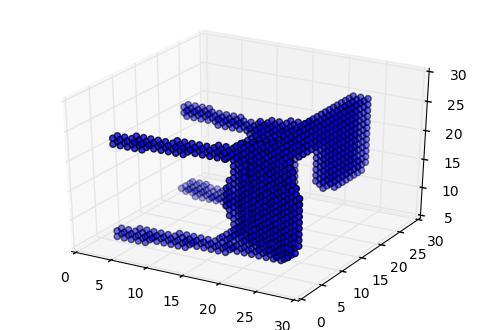

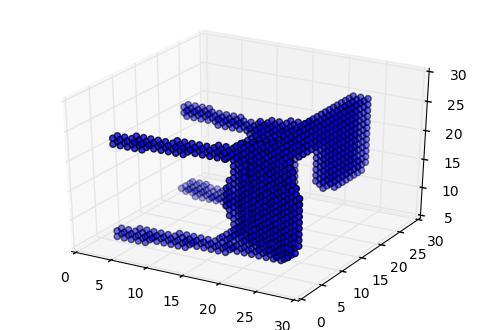

In [39]:
x, y, z = np.where(np.logical_and(df_v>0, df_v<1))
points = np.vstack((x, y, z)).T
Point_Cloud(points=points).plot()

In [30]:
export_distance_field_to_text('/Users/optas/Desktop/test.df', df_v)
export_distance_field_to_text('/Users/optas/Desktop/test.sdf', sdf_v)

In [6]:
experiment_name = 'debug'

do_training = False
do_plotting = False

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

full_pclouds_path = '/Users/optas/DATA/Point_Clouds/Shape_Net_Core/from_manifold_meshes/1024/03001627/'

train_dir = osp.join('/Users/optas/Desktop/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/Users/optas/Desktop/debug'

In [8]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_file_names = full_file_names[:300]
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=4)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

300 files containing complete point clouds were found.


In [17]:
train_data_, val_data_, test_data_, r_indices = pio.train_validate_test_split([full_pclouds, 
                                                                    full_model_names],
                                                                    train_perc=0.85,
                                                                    validate_perc=0.05,
                                                                    test_perc=0.1,                                                                   
                                                                    seed=seed)

model_ids = np.vstack((full_model_names, full_syn_ids)).T
write_model_ids_of_datasets(train_dir, model_ids, r_indices)

train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [26]:
reset_tf_graph()

n_input = [1024, 3]

decoder_args = {'layer_sizes': [1024, np.prod(n_input)], 
                'non_linearity': tf.nn.relu, 
                'b_norm': False
               }

encoder_args = {'b_norm': False, 'spn': False, 'symmetry': tf.reduce_sum}

experiment_name = 'test'
 
conf = Conf(
            n_input = n_input,
            training_epochs = 5,
            batch_size = 5,
            loss = 'l2',
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = 1,
            learning_rate = 0.00002,
            saver_max_to_keep = 100,
            gauss_augment = {'mu': 0, 'sigma': 0.02},
            
            encoder = enc_dec.encoder_with_convs_and_symmetry,
            encoder_args = encoder_args,
            decoder = enc_dec.decoder_with_fc_only,
            decoder_args = decoder_args,
            experiment_name = experiment_name
           )


ae = PointNetAutoEncoder('test', conf)

In [27]:
# ae.train(train_data, conf)
saved_epochs = read_saved_epochs(conf.train_dir)
ae.restore_model(train_dir, saved_epochs[-1])

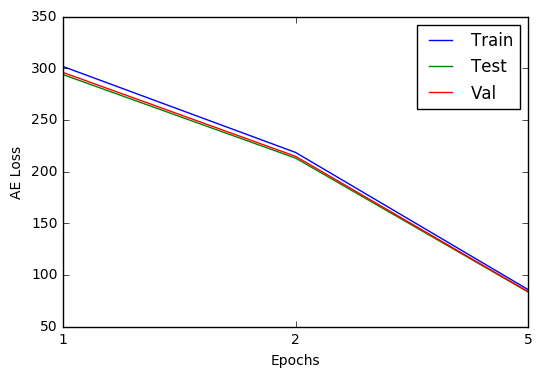

In [33]:
# val_data.num_examples
if True:
    saved_epochs = read_saved_epochs(conf.train_dir)
    plot_epochs = select_first_last_and_k(saved_epochs, 1)
    stats = eval_model(ae, conf, [train_data, val_data, test_data], epochs=plot_epochs)
    last_epoch = saved_epochs[-1]
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')    
    plot_train_val_test_curves(stats, top_save_dir, has_validation=True, best_epoch=None, show=True)    
    
    save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=250)
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=250)

In [34]:
mesh_file = '/Users/optas/DATA/Shapes/Ersin_semantic/Airplanes/001.obj'

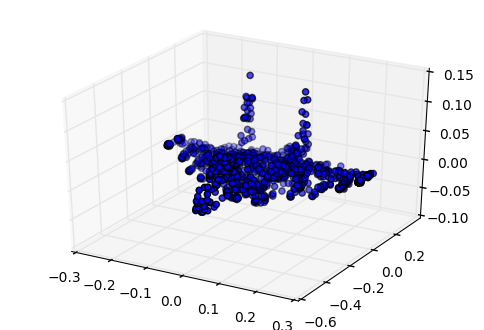

In [61]:
from geo_tool import Mesh
import geo_tool.solids.mesh_cleaning as cleaning
n_samples = 1024
dtype = np.float32
swap_y_z = True
in_mesh = Mesh(file_name=mesh_file)
model_id = mesh_file.split('/')[-2]
if swap_y_z:
    in_mesh.swap_axes_of_vertices([0, 2, 1])
in_mesh = cleaning.clean_mesh(in_mesh)
ss_points, _ = in_mesh.sample_faces(n_samples)
pc = Point_Cloud(ss_points.astype(dtype))
pc = pc.center_in_unit_sphere()

pc1, _ = pc.lex_sort()
pc1.plot();